In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

In [2]:
import whisper

def transcribe_audio(filename):
    model = whisper.load_model("base")
    result = model.transcribe(filename)
    return result["text"]

def extract_numbers(text):
    numbers = ''.join(filter(str.isdigit, text))
    return numbers

if __name__ == "__main__":
    #transcription = transcribe_audio('742번.m4a')
    transcription = transcribe_audio('1500번.m4a')

    print("your audio:", transcription)

    want_bus = extract_numbers(transcription)
    print("audio recognized:", want_bus)


c:\anaconda3\lib\site-packages\whisper\transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


your audio:  1500번
audio recognized: 1500


In [ ]:
class ObjectDetection:
    def __init__(self):
        self.model = torch.hub.load("ultralytics/yolov5", "yolov5s")
        self.cap = cv2.VideoCapture(0)

    def run(self):
        while True:
            ret, frame = self.cap.read()
            results = self.model(frame)
            current_detection = []

            for detection in results.xyxy[0]:
                class_id = int(detection[5])
                class_label = self.model.names[class_id]
                if class_label == "bus":
                    current_detection.append(class_label)

            frame = results.render()[0]
            cv2.imshow("Frame", frame)

            # 버스 인지되면 캡처
            if "bus" in current_detection:
                #time.sleep(2)
                timestamp = time.strftime("%Y%m%d_%H%M%S")
                filename = f"bus_capture_{timestamp}.png"
                cv2.imwrite(filename, frame)
                print(f"버스 인지됨, {filename}로 저장")
                return filename
                break  # 한 번 찍기

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        self.cap.release()
        cv2.destroyAllWindows()
        
# obj_detector = ObjectDetection()
# filename = obj_detector.run()

# if filename:
#     img_ori = cv2.imread(filename)
#     if img_ori is None:
#         print(f"fail to read captured image: {filename}")

Text(0.5, 1.0, 'BGR2GRAY')

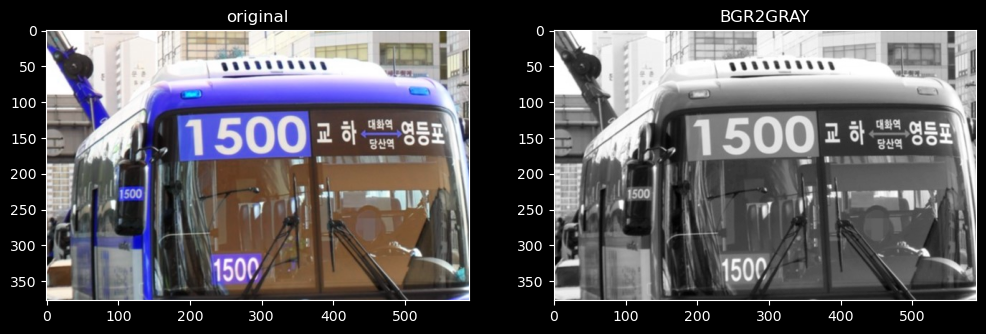

In [3]:
#img_ori = cv2.imread('742.png')
img_ori = cv2.imread('1500.jpg')

height, width, channel = img_ori.shape
# plt.figure(figsize=(12, 10))
# plt.imshow(img_ori,cmap='gray')
# print(height, width, channel)
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))

plt.subplot(1,2,1)
plt.imshow(img_ori)
plt.title('original')

plt.subplot(1,2,2)
plt.imshow(gray, cmap='gray')
plt.title('BGR2GRAY')

Text(0.5, 1.0, 'contour')

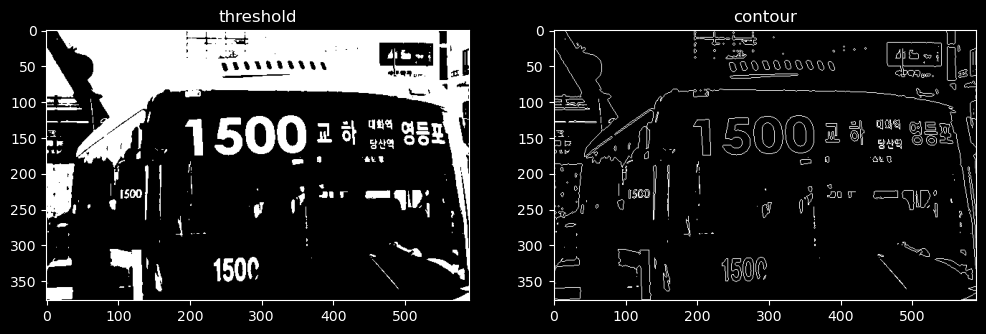

In [4]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

_, img_thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))

plt.figure(figsize=(12, 10))

plt.subplot(1,2,1)
plt.imshow(img_thresh, cmap='gray')
plt.title('threshold')

plt.subplot(1,2,2)
plt.imshow(temp_result)
plt.title('contour')

In [5]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)
    
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })
    

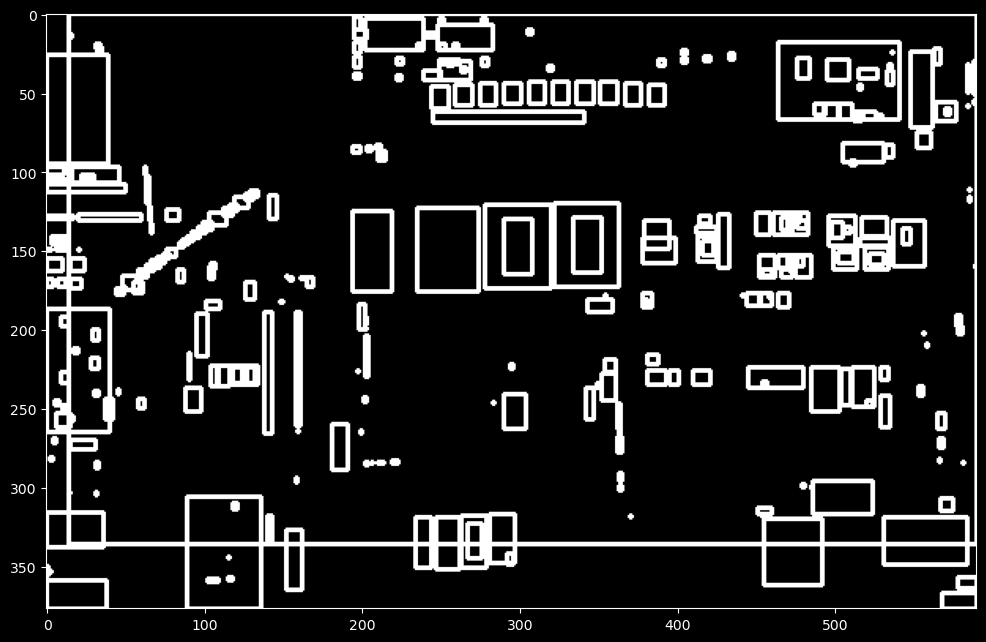

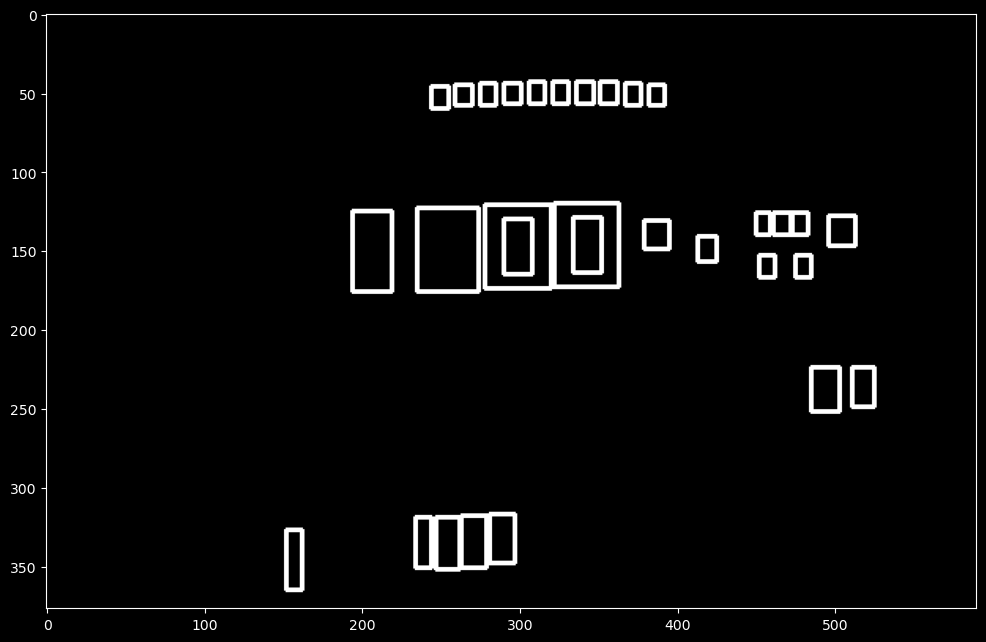

In [6]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT=2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 2

plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

temp_result = np.zeros((height, width, channel), dtype = np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
    
# plt.figure(figsize=(12, 10))
# plt.imshow(temp_result, cmap='gray')

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
                
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
                
        matched_contours_idx.append(d1['idx'])
        
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
            
        matched_result_idx.append(matched_contours_idx)
        
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            
        break
        
    return matched_result_idx



result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)


plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

C:\Users\김민서\AppData\Local\Temp\ipykernel_4972\3664141208.py:40: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(plate_imgs[-1], cmap='gray')


1
0
1500
15






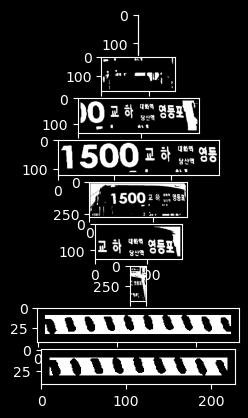

In [7]:
PLATE_WIDTH_PADDING = 4 
PLATE_HEIGHT_PADDING = 5 
MIN_PLATE_RATIO = 3  
MAX_PLATE_RATIO = 10 

plate_imgs = [] 
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

    sum_height = sum(char['h'] for char in sorted_chars)

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

    plate_aspect_ratio = plate_width / plate_height
    if plate_aspect_ratio < MIN_PLATE_RATIO or plate_aspect_ratio > MAX_PLATE_RATIO:
        if plate_aspect_ratio < MIN_PLATE_RATIO:
            plate_width = plate_height * MIN_PLATE_RATIO
        else:
            plate_height = plate_width / MAX_PLATE_RATIO

    plate_imgs.append(img_thresh[
        int(plate_cy - plate_height / 2): int(plate_cy + plate_height / 2),
        int(plate_cx - plate_width / 2): int(plate_cx + plate_width / 2)
    ])
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })

    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(plate_imgs[-1], cmap='gray')

# plt.show()
#-----------------------------------------------------------------------------#
longest_idx, longest_text = -1, 0
plate_chars = []
p = 0

# 처음에 선별되지 못한 후보군에 대해서도 판별 ex)버스 번호 한 자리인 경우
for i, plate_img in enumerate(plate_imgs):
    # 이미지가 비어 있는지 확인
    if plate_img.size == 0:
        continue

    # 이미지 크기 조정
    plate_img_resized = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)

    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img_resized, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

    plate_min_x, plate_min_y = plate_img_resized.shape[1], plate_img_resized.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h

    # 이미지 크롭
    img_result = plate_img_resized[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    if img_result.size == 0:
        p += 1
        continue

    # 이미지 전처리
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

    # Tesseract를 사용하여 문자 인식
    pytesseract.pytesseract.tesseract_cmd = 'C:/tesseract/tesseract.exe'
    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 6 --oem 0')

    # pytesseract 결과가 비어있지 않은 경우에만 처리
    if chars.strip():  
        result_chars = ''
        has_digit = False
        for c in chars:
            if c.isdigit():
                has_digit = True
                result_chars += c

        # 결과 출력
        print(result_chars)
        plate_chars.append(result_chars)

        if has_digit and len(result_chars) > longest_text:
            longest_idx = i + p

        # 이미지 플로팅
        plt.subplot(len(plate_imgs), 1, i + 1)
        plt.imshow(img_result, cmap='gray')

# 결과 출력
plt.show()


In [8]:
import pyttsx3

engine = pyttsx3.init()

info = plate_infos[longest_idx]
unique_plate_chars = set()

for chars in plate_chars:
    if chars.strip():
        if chars not in unique_plate_chars and chars == want_bus:
            print("recognized bus:", chars)
            unique_plate_chars.add(chars)
            additional_message = " 번 버스가 전방에 들어오고 있으니 조심해서 승차하세요."
            full_message = chars + " " + additional_message

            engine.setProperty('rate', 150)  # Speed of speech
            engine.say(full_message)
            engine.runAndWait()


recognized bus: 1500
